* https://plot.ly/python/maps/
* https://data.sfgov.org/Economy-and-Community/Mobile-Food-Facility-Permit/rqzj-sfat

To do:

* Run statistical test on samples
* Create map
* Write-up

Food cart history:

* https://www.history.com/news/from-chuck-wagons-to-pushcarts-the-history-of-the-food-truck
* https://mobile-cuisine.com/business/history-of-american-food-trucks/

From timeless classics like the House of Prime Rib to bizarre fusions like Sushirrito, San Francisco (SF) is know for its diverse food scene. But roaming up and down the crowded streets of SF are hundreds of mobile food facilities. These fast, casual pseudo resturants can be found on street corners selling mysterious meat wrapped in bacon or sprawled as far as the eye can see at their own festival. 

A mobile food facility must be permitted by the the City of San Francisco to legally sell food. The city of San Francisco publishes partial information of permit applications on their website. Two types of mobile food facilities are recognized: push carts and food trucks.

From this data we will create a interactive map of the location all the permitted food facilites in SF. [While there are websites that allow food trucks to update their location, many food push carts do not utilize this tool.]

In [34]:
import plotly.plotly as py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
pd.set_option('display.max_columns', None)
sns.set_style('darkgrid')

# Importing Data

Get a sense of the data.

In [4]:
sf = pd.read_csv('data/Mobile_Food_Facility_Permit.csv')
sf.shape

(632, 24)

In [5]:
sf.head()

,locationid,Applicant,FacilityType,cnn,LocationDescription,Address,blocklot,block,lot,permit,Status,FoodItems,X,Y,Latitude,Longitude,Schedule,dayshours,NOISent,Approved,Received,PriorPermit,ExpirationDate,Location
0,1152244,San Francisco's Hometown Creamery,Truck,6109000,GEARY ST: STOCKTON ST to POWELL ST (200 - 299),281 GEARY ST,0314013,0314,013,17MFF-0001,APPROVED,Ice cream,6010423.418,2114694.802,37.787136,-122.407719,http://bsm.sfdpw.org/PermitsTracker/reports/re...,Su:11AM-11PM;Fr/Sa:6PM-11PM,NaN,10/16/2018 12:00:00 AM,2017-01-09,0,07/15/2019 12:00:00 AM,"(37.7871364910861, -122.407718509001)"
1,751253,Pipo's Grill,Truck,5688000,FOLSOM ST: 14TH ST to 15TH ST (1800 - 1899),1800 FOLSOM ST,3549083,3549,083,16MFF-0010,REQUESTED,Tacos: Burritos: Hot Dogs: and Hamburgers,6007856.719,2107724.046,37.767852,-122.416105,http://bsm.sfdpw.org/PermitsTracker/reports/re...,NaN,NaN,NaN,2016-02-04,0,NaN,"(37.7678524427181, -122.416104892532)"
2,735318,Ziaurehman Amini,Push Cart,30727000,MARKET ST: DRUMM ST intersection,5 THE EMBARCADERO,0234017,0234,017,15MFF-0159,REQUESTED,NaN,6013916.720,2117244.027,37.794331,-122.395811,http://bsm.sfdpw.org/PermitsTracker/reports/re...,NaN,NaN,NaN,2015-12-31,0,03/15/2016 12:00:00 AM,"(37.7943310032468, -122.395811053023)"
3,364218,The Chai Cart,Push Cart,9543000,NEW MONTGOMERY ST: AMBROSE BIERCE ST to MISSIO...,79 NEW MONTGOMERY ST,3707014,3707,014,12MFF-0083,SUSPEND,Hot Indian Chai (Tea),6012504.312,2114926.774,37.787890,-122.400535,http://bsm.sfdpw.org/PermitsTracker/reports/re...,Mo-Su:7AM-6PM,NaN,NaN,2012-04-03,0,NaN,"(37.7878896999061, -122.400535326777)"
4,735315,Ziaurehman Amini,Push Cart,4969000,DRUMM ST: MARKET ST to CALIFORNIA ST (1 - 6),1 CALIFORNIA ST,0264004,0264,004,15MFF-0159,REQUESTED,NaN,6013552.570,2116844.500,37.793214,-122.397043,http://bsm.sfdpw.org/PermitsTracker/reports/re...,NaN,NaN,NaN,2015-12-31,0,03/15/2016 12:00:00 AM,"(37.7932137316634, -122.397043036718)"


# Cleaning Data

Each row represents a single applicant. A applicant can appear multiple times, but I belive they are for seperate locations.

In [6]:
sf['Applicant'].nunique()

113

So I want to remove all the duplicate applicants, that apply for the same location. If a applicant has mutiple locations that's fine, I just don't want applicants that apply and then reapply for the same location.

I'll solve this by removing observations with the same Applicant and Location. While there can be multiple locations per applicant and multiple applicants per location, it is unlikely that the same applicant is requesting multiple permits for the same location. In the real world, this means that a single applicant is setting up multiple food facilities on the same corner. This does not make business sense, so these instances will be excluded and assumed that it is instead applicants reapplying for the same location. 

Drops rows that have duplicate Applicant and Location columns.

In [7]:
sf.drop_duplicates(subset=['Applicant','Location'], inplace=True)

Some of the Locations are (0,0). While they do have a Address attached to them finding the latitute and longitude of each address would be too time consuming. Instead, observations with Latitutde with value of 0 will simply be dropped.

In [8]:
sf = sf.loc[sf['Latitude'] != 0]

# EDA

The vast majority of the permits are for food trucks. Only 51 permits are for food push carts.

Text(0.5, 1.0, 'Permitted facility counts')

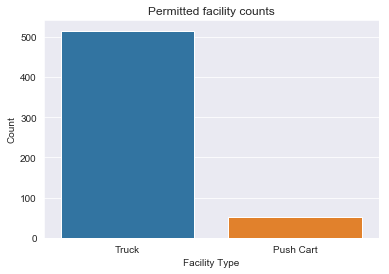

In [12]:
sns.countplot('FacilityType', data=sf)
plt.xlabel('Facility Type')
plt.ylabel('Count')
plt.title('Permitted facility counts')

A barplot of the number of permits per applicant.

In [86]:
sf_app = sf.groupby(['Applicant']).size().to_frame('Count')

sf_app.index.name = 'Applicant'
sf_app.reset_index(inplace=True)
sf_app.sort_values(by=['Count'], inplace=True)

In [87]:
sf_app_breakdown = sf_app.groupby('Count').count()

sf_app_breakdown['Percentage'] = sf_app_breakdown['Applicant']/sf_app_breakdown['Applicant'].sum()
sf_app_breakdown

,Applicant,Percentage
Count,,
1,35,0.321101
2,24,0.220183
3,13,0.119266
4,10,0.091743
5,4,0.036697
6,4,0.036697
7,2,0.018349
8,2,0.018349
11,1,0.009174


A barplot of the number of permits per applicant is displayed below. Because we removed duplicates, this graph also shows the number of locations per applicant. 32% of applicants only have one location and 86% of applicants have less than 10 locations. The top 10 applicants hold 48% of the permits. The applicant with the most permits, May Catering, holds 9% of all permits with 52 total permits.

Text(0.5, 1.0, 'Permits per applicant')

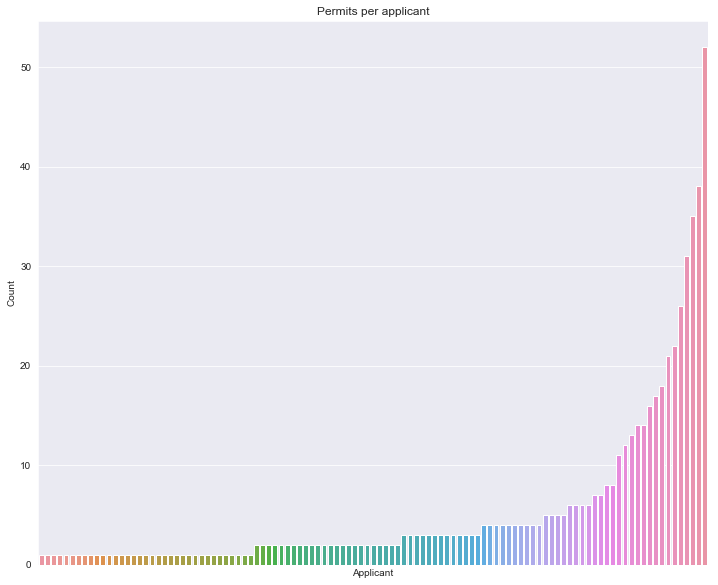

In [88]:
plt.figure(figsize=(12,10))

sns.barplot('Applicant', 'Count', data=sf_app)

plt.xticks([])
plt.xlabel('Applicant')
plt.ylabel('Count')

plt.title('Permits per applicant')

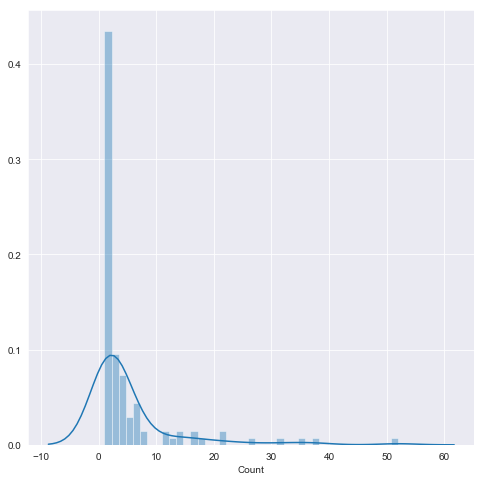

In [91]:
plt.figure(figsize=(8,8))
sns.distplot(sf_app['Count'])

In [121]:
sf.describe()

,locationid,cnn,X,Y,Latitude,Longitude,PriorPermit
count,5.760000e+02,5.760000e+02,5.760000e+02,5.760000e+02,576.000000,576.000000,576.000000
mean,1.111839e+06,6.734556e+06,6.011461e+06,2.106587e+06,37.764931,-122.403561,0.737847
std,1.300380e+05,4.863518e+06,5.147627e+03,8.474579e+03,0.023204,0.017953,0.440188
min,3.349140e+05,0.000000e+00,5.985031e+06,2.086365e+06,37.709375,-122.494378,0.000000
25%,1.024050e+06,2.953750e+06,6.009778e+06,2.100487e+06,37.748428,-122.409597,0.000000
50%,1.181850e+06,6.775500e+06,6.012651e+06,2.107898e+06,37.768314,-122.399884,1.000000
75%,1.184849e+06,9.355250e+06,6.014952e+06,2.114204e+06,37.785922,-122.391244,1.000000
max,1.272280e+06,3.074700e+07,6.019957e+06,2.122294e+06,37.807743,-122.373303,1.000000


In [134]:
sf['Status'].value_counts()

APPROVED     378
REQUESTED    110
EXPIRED       77
SUSPEND        5
ISSUED         4
INACTIVE       1
ONHOLD         1
Name: Status, dtype: int64

Check if distributions representative of the population.

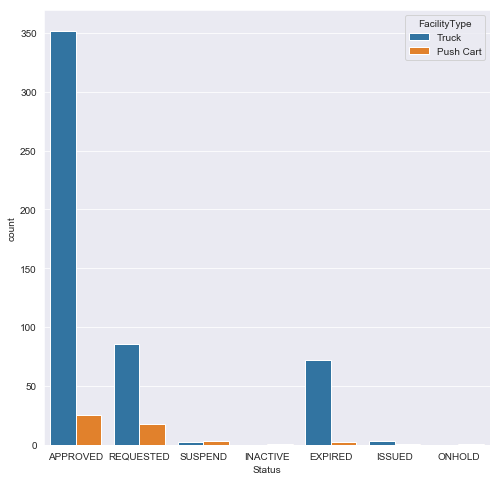

In [135]:
plt.figure(figsize=(8,8))
sns.countplot('Status', hue='FacilityType', data=sf)

In [129]:
sf['PriorPermit'].value_counts()

1    425
0    151
Name: PriorPermit, dtype: int64

151 of the applications have not had a prior permit while the remaining 425 applications have had only 1 prior permit.

Text(0.5, 1.0, 'Count of prior permits')

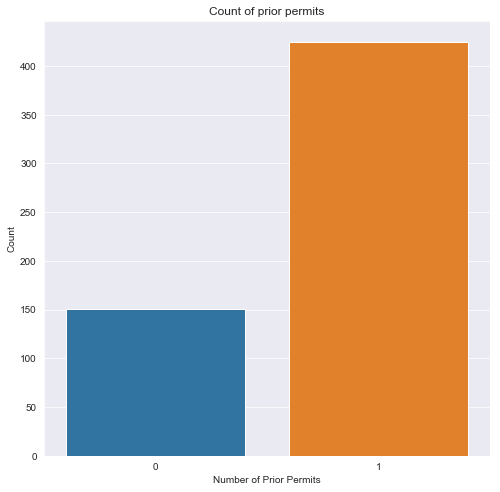

In [132]:
plt.figure(figsize=(8,8))
sns.countplot('PriorPermit', data=sf)

plt.xlabel('Number of Prior Permits')
plt.ylabel('Count')
plt.title('Count of prior permits')

Get the food items, facilitytype of the 10 most numerous food places

In [110]:
top_10 = sf_app.tail(10)

top_10_crossed = pd.merge(top_10, sf, on='Applicant')

top_10_crossed.head()

,Applicant,Count,locationid,FacilityType,cnn,LocationDescription,Address,blocklot,block,lot,permit,Status,FoodItems,X,Y,Latitude,Longitude,Schedule,dayshours,NOISent,Approved,Received,PriorPermit,ExpirationDate,Location
0,D & T Catering,16,1184104,Truck,13448000,WASHINGTON ST: LAUREL ST to LOCUST ST (3500 - ...,3550 WASHINGTON ST,0986009,0986,009,18MFF-0057,APPROVED,Cold Truck: Pre-packaged sandwiches: Chicken B...,5.997757e+06,2.115878e+06,37.789667,-122.451628,http://bsm.sfdpw.org/PermitsTracker/reports/re...,Mo-Fr:9AM-10AM,NaN,07/11/2018 12:00:00 AM,2018-07-11,1,07/15/2019 12:00:00 AM,"(37.7896668269621, -122.451627836117)"
1,D & T Catering,16,1184113,Truck,10163000,PACIFIC AVE: LYON ST to PRESIDIO AVE \ PRESIDI...,3100 PACIFIC AVE,0965006,0965,006,18MFF-0057,APPROVED,Cold Truck: Pre-packaged sandwiches: Chicken B...,5.999234e+06,2.116707e+06,37.792029,-122.446577,http://bsm.sfdpw.org/PermitsTracker/reports/re...,Mo-Fr:10AM-11AM,NaN,07/11/2018 12:00:00 AM,2018-07-11,1,07/15/2019 12:00:00 AM,"(37.7920290580811, -122.446576890144)"
2,D & T Catering,16,1184102,Truck,7417000,JACKSON ST: MAPLE ST to CHERRY ST (3700 - 3799),3756 JACKSON ST,0968007,0968,007,18MFF-0057,APPROVED,Cold Truck: Pre-packaged sandwiches: Chicken B...,5.996275e+06,2.115996e+06,37.789908,-122.456763,http://bsm.sfdpw.org/PermitsTracker/reports/re...,Mo-Fr:9AM-10AM,NaN,07/11/2018 12:00:00 AM,2018-07-11,1,07/15/2019 12:00:00 AM,"(37.7899082332987, -122.456762533982)"
3,D & T Catering,16,1184105,Truck,11708000,SCOTT ST: PACIFIC AVE to BROADWAY (2500 - 2599),2521 SCOTT ST,0961002,0961,002,18MFF-0057,APPROVED,Cold Truck: Pre-packaged sandwiches: Chicken B...,6.001109e+06,2.117139e+06,37.793323,-122.440119,http://bsm.sfdpw.org/PermitsTracker/reports/re...,Mo-Fr:9AM-10AM,NaN,07/11/2018 12:00:00 AM,2018-07-11,1,07/15/2019 12:00:00 AM,"(37.7933225090245, -122.440119274474)"
4,D & T Catering,16,1184106,Truck,3183000,BROADWAY: DIVISADERO ST to BRODERICK ST (2700 ...,2710 BROADWAY,0959007,0959,007,18MFF-0057,APPROVED,Cold Truck: Pre-packaged sandwiches: Chicken B...,6.000568e+06,2.117281e+06,37.793681,-122.442002,http://bsm.sfdpw.org/PermitsTracker/reports/re...,Mo-Fr:9AM-10AM,NaN,07/11/2018 12:00:00 AM,2018-07-11,1,07/15/2019 12:00:00 AM,"(37.7936813457741, -122.442002100568)"


I want a statistical test to see if this is representative of the population.

* https://stats.stackexchange.com/tags/tost/info
* https://stats.stackexchange.com/questions/97549/check-if-sample-is-representative-of-a-larger-sample

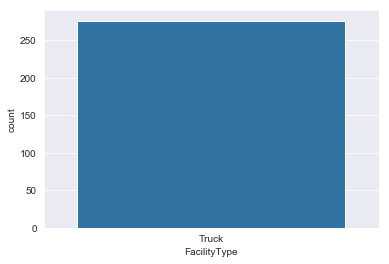

In [112]:
sns.countplot('FacilityType', data=top_10_crossed)

In [114]:
top_10_crossed['FoodItems'].unique()

array(['Cold Truck: Pre-packaged sandwiches: Chicken Bake: Canned Soup: Chili Dog: Corn Dog: Cup of Noodles: Egg Muffins: Hamburgers: Cheeseburgers: Hot Dog: Hot sandwiches: quesadillas: Beverages: Flan: Fruits: Yogurt: Candy: Cookies: Chips: Donuts: Snacks',
       'COLD TRUCK. Deli: bbq chicken skewer: Chinese spring roll: Chinese fried rice/noodle: fried chicken leg/wing: bbq chicken sandwich: chicken cheese burger: burrito: lumpia. Snack: sunflower seeds: muffins: chips: snickers: kit-kat: 10 types of chocolate. Drinks: Coke: 7-Up: Dr. Pepper: Pepsi: Redbull: Vitamin Water: Rockstar: Coconut Juice: Water. Hot drinks: coffee: tea.',
       'Cold Truck: Soda:Chips:Candy: Cold/Hot Sandwiches: Donuts.  (Pitco Wholesale)',
       'Ice Cream: Pre-Packaged Chips: Candies: Bottled Water & Canned SODA',
       'Cold Truck: Hamburger: cheeseburgers: hot dogs: hot sandwiches: cold sandwiches: egg muffins: cup of noodles: corn dogs: canned soup: coffee: hot cocoa: hot tea: gatorade: juice: mil